In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)
import shared_utils

from calitp_data_analysis import get_fs
from calitp_data_analysis.tables import tbls
import calitp_data_analysis.magics

from siuba import *
import pandas as pd
import geopandas as gpd

import datetime as dt

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Updating procedure for updating Conveyal network bundles

* much of this could be in DBT?

In [2]:
target_date = dt.date(2023, 9, 1)

In [3]:
feeds_on_target = shared_utils.gtfs_utils_v2.schedule_daily_feed_to_gtfs_dataset_name(selected_date=target_date)
# default will use mtc subfeeds (prev Conveyal behavior), can spec customer facing if we wanna switch

In [4]:
feeds_on_target >> head(3)

,key,date,feed_key,feed_timezone,base64_url,gtfs_dataset_key,gtfs_dataset_name,name,regional_feed_type,type
0,f95a4142a38ae102a7a07cbad9de37fe,2023-09-01,e34cf65857aa8ad042e2446d053264c1,America/Los_Angeles,aHR0cHM6Ly90Y3J0YS50cmlwc2hvdC5jb20vdjEvZ3Rmcy...,0139b1253130b33adcd4b3a4490530d2,TCRTA TripShot Schedule,TCRTA TripShot Schedule,None,schedule
1,cccf568bbb9014e54866541b3c3d43cc,2023-09-01,4ca29da6f3017b5f6cacf687e0572543,America/Los_Angeles,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,015d67d5b75b5cf2b710bbadadfb75f5,Bay Area 511 Marin Schedule,Bay Area 511 Marin Schedule,Regional Subfeed,schedule
2,3b5ba7d9f7885aef7a7e29de98f6afb0,2023-09-01,5e1be3854cae4470eccf4a1323526e3a,America/Los_Angeles,aHR0cHM6Ly9naXRodWIuY29tL0xBQ01UQS9sb3MtYW5nZW...,04540587c205fb3b1a86b76badacb919,Playa Vista Schedule,Playa Vista Schedule,None,schedule


In [5]:
feeds_on_target >> filter(_.gtfs_dataset_name.str.contains('LA Metro'))

,key,date,feed_key,feed_timezone,base64_url,gtfs_dataset_key,gtfs_dataset_name,name,regional_feed_type,type
35,d57a52a00f514304f3fd226839193df1,2023-09-01,92d57c4c4cbc31f075583e14153cb9be,America/Los_Angeles,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,2a0571758141f412b6a546fd70a65bf3,LA Metro Rail Schedule,LA Metro Rail Schedule,None,schedule
48,c9acd8fa8862ed4d6b7535b236f8e0fb,2023-09-01,edb0fd72b98a7f739407ceca3fae9034,America/Los_Angeles,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX2J1cy...,3f3f36b4c41cc6b5df3eb7f5d8ea6e3c,LA Metro Bus Schedule,LA Metro Bus Schedule,None,schedule


In [6]:
metro_test = (feeds_on_target >> filter(_.gtfs_dataset_name.str.contains('LA Metro'))).base64_url.iloc[0]

## Stops --> Region matching

In [7]:
regions = {}
# Set bounds for northern california
regions['norcal'] = {'north': 42.03909, 'south': 39.07038, 'east': -119.60541, 'west': -124.49158}
regions['central'] = {'north': 39.64165, 'south': 35.87347, 'east': -117.53174, 'west': -123.83789}
regions['socal'] = {'north': 35.8935, 'south': 32.5005, 'east': -114.13121, 'west': -121.46759}
regions['mojave'] = {'north': 37.81629, 'south': 34.89945, 'east': -114.59015, 'west': -118.38043}

In [8]:
import shapely

In [45]:
# https://shapely.readthedocs.io/en/stable/reference/shapely.box.html#shapely.box
# xmin, ymin, xmax, ymax
to_bbox = lambda x: [x['west'], x['south'], x['east'], x['north']]

In [38]:
df = pd.DataFrame(regions).transpose().reset_index().rename(columns={'index':'region'})

In [39]:
df['bbox'] = df.apply(to_bbox, axis=1)

In [40]:
df

,region,north,south,east,west,bbox
0,norcal,42.03909,39.07038,-119.60541,-124.49158,"[-124.49158, 39.07038, -119.60541, 42.03909]"
1,central,39.64165,35.87347,-117.53174,-123.83789,"[-123.83789, 35.87347, -117.53174, 39.64165]"
2,socal,35.89350,32.50050,-114.13121,-121.46759,"[-121.46759, 32.5005, -114.13121, 35.8935]"
3,mojave,37.81629,34.89945,-114.59015,-118.38043,"[-118.38043, 34.89945, -114.59015, 37.81629]"


In [42]:
df['geometry'] = df.apply(lambda x: shapely.geometry.box(*x.bbox), axis = 1)

In [43]:
gdf = gpd.GeoDataFrame(df, crs=shared_utils.geography_utils.WGS84)

In [44]:
gdf.explore()

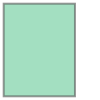

In [35]:
gdf.geometry.iloc[3]

## Validation steps here!

In [35]:
validation_tbl = tbls.mart_gtfs_quality.fct_daily_schedule_feed_validation_notices()

In [52]:
## apparently busted since moving to v4.1 on Sep 1??
validation_df = (validation_tbl >> filter(_.date == '2023-09-01')
                                # >> distinct(_.base64_url, _.severity)
                            ) >> collect()

In [54]:
# validation_df

In [56]:
# validation_df.severity.value_counts()

## Download raw from GCS (for Conveyal)

In [8]:
fs = get_fs()

In [30]:
base64_url = metro_test

In [31]:
# need wildcard for file too -- not all are gtfs.zip!
uri = f'gs://calitp-gtfs-schedule-raw-v2/schedule/dt={target_date}/*/base64_url={base64_url}/*.zip'

In [32]:
fs.get(uri, './gtfs.zip')

[None]

In [ ]:
def 